# StyleGAN2 Face Morphing Basics

This is a example notebook of how to use StyleGAN2 to generate morphed faces. The code is from [woctezuma's fork of Stylegan2](https://github.com/woctezuma/stylegan2/tree/tiled-projector) as well as [Pbatch's repository](https://github.com/Pbatch/StyleGANSecretSanta). I recomend checking them out if you want to get a better understanding of StyleGAN2 in general.

Last tested on September 2023

## Step 0: Set up the enviroment

- Make sure you use GPU hardware acceleration in Google colab. Go to ```Runtime > Change Runtime type``` and choose ```T4 GPU```.
- We need to clone StyleGAN2 from the official Gtihub repository.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 5.82 MiB/s, done.
Resolving deltas: 100% (57/57), done.


- Then, we install all the required libraries. Also we will need to downgrade the Pillow library in order to run the script that aligns and crops the images (same script is used in the official FFHQ dataset)
- You may need to Restart the Runtime in this step (as seen bellow)

In [ ]:
!pip install dlib numpy scipy
!pip install Pillow==9.5.0
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 3.6 MB/s eta 0:00:00


- Finally, lets get two pictures in order to perform the morphing procegure. We will keep the original images in a directory called ```raw```.

In [ ]:
!mkdir raw

!wget -P raw/ https://i2-prod.examinerlive.co.uk/incoming/article27326695.ece/ALTERNATES/s1200c/0_PROD-Clarksons-Farm-Photocall.jpg

!wget -P raw/ https://images.immediate.co.uk/production/volatile/sites/3/2019/12/GettyImages-1094600904-0ccc937-scaled.jpg

# rename image files
!mv raw/0_PROD-Clarksons-Farm-Photocall.jpg raw/jeremy.jpg
!mv raw/GettyImages-1094600904-0ccc937-scaled.jpg raw/james.jpg

--2023-09-22 13:56:06--  https://i2-prod.examinerlive.co.uk/incoming/article27326695.ece/ALTERNATES/s1200c/0_PROD-Clarksons-Farm-Photocall.jpg
Resolving i2-prod.examinerlive.co.uk (i2-prod.examinerlive.co.uk)... 99.84.160.120, 99.84.160.15, 99.84.160.80, ...
Connecting to i2-prod.examinerlive.co.uk (i2-prod.examinerlive.co.uk)|99.84.160.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78906 (77K) [image/webp]
Saving to: ‘raw/0_PROD-Clarksons-Farm-Photocall.jpg’

0_PROD-Clarksons-Fa 100%[===================>]  77.06K  --.-KB/s    in 0.02s   

2023-09-22 13:56:06 (3.62 MB/s) - ‘raw/0_PROD-Clarksons-Farm-Photocall.jpg’ saved [78906/78906]

--2023-09-22 13:56:06--  https://images.immediate.co.uk/production/volatile/sites/3/2019/12/GettyImages-1094600904-0ccc937-scaled.jpg
Resolving images.immediate.co.uk (images.immediate.co.uk)... 151.101.2.137, 151.101.66.137, 151.101.130.137, ...
Connecting to images.immediate.co.uk (images.immediate.co.uk)|151.101.2.137|:44

Now let's view the images before we process them.

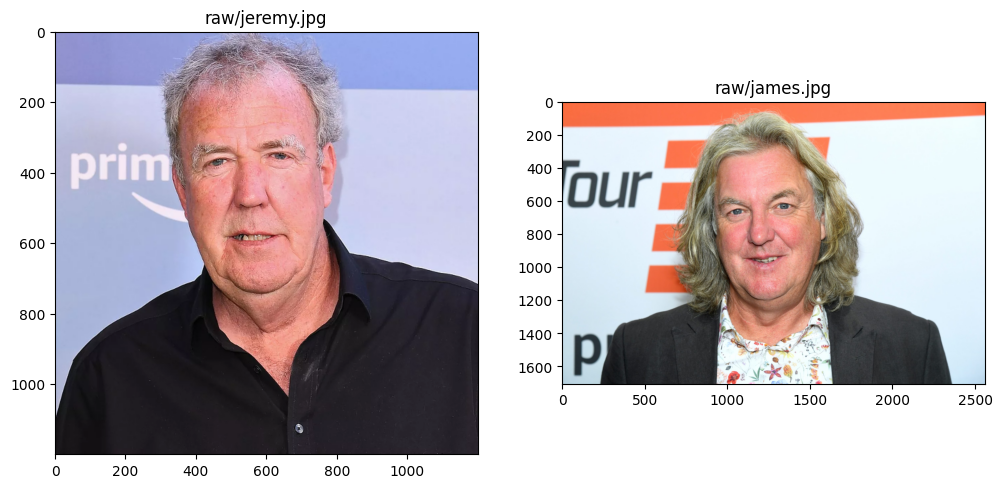

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(12,12))

plt.subplot(1,2,1).set_title("raw/jeremy.jpg")
plt.imshow(Image.open('raw/jeremy.jpg'))


plt.subplot(1,2,2).set_title("raw/james.jpg")
plt.imshow(Image.open('raw/james.jpg'))



## Step 1: Alignement
The model we are going to use has been trained with the [FFHQ dataset](https://github.com/NVlabs/ffhq-dataset). Therefore our images need to be at 1024×1024 resolution and the face must be centerned in the same way. If not, the projection will not detect the facial features correctly.

We are going to align our images by using the same code from the FFHQ dataset. The code works by using an existing Landmark Detector to find the pixels of facial features. We need to download a .dat file in order to use the Detector.

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2023-09-22 13:56:21--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  76.3MB/s    in 0.8s    

2023-09-22 13:56:22 (76.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



The file is compressed as a .bz2. We need to decompress it.

In [ ]:
import bz2

def unpack_bz2(filepath):
    '''
    Auxiliary function

    decompress a .bz2 file and extracts in the current directory

    source: https://stackoverflow.com/questions/16963352/decompress-bz2-files
    '''
    zipfile = bz2.BZ2File(filepath)     # open the file
    data = zipfile.read()               # get the decompressed data
    newfilepath = filepath[:-4]         # assuming the filepath ends with .bz2
    open(newfilepath, 'wb').write(data) # write a uncompressed file

unpack_bz2('shape_predictor_68_face_landmarks.dat.bz2')

In [ ]:
# source: https://github.com/woctezuma/stylegan2/tree/tiled-projector

import dlib


class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = dlib.get_frontal_face_detector()
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = dlib.load_rgb_image(image)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [(item.x, item.y) for item in self.shape_predictor(img, detection).parts()]
            yield face_landmarks


In [ ]:
# source: https://github.com/woctezuma/stylegan2/tree/tiled-projector

import numpy as np
import scipy.ndimage
import os
import sys
import PIL

def create_aligned_image(src_file, out_file, face_landmarks, output_size=1024, transform_size=4096, enable_padding=True):

        # Parse landmarks.
        # pylint: disable=unused-variable
        lm = np.array(face_landmarks)
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1

        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # Load unaligned image.
        if not os.path.isfile(src_file):
            print('\nCannot find source image. Please run "--wilds" before "--align".')
            return
        img = PIL.Image.open(src_file)

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]

        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS) # ANTIALIAS is deprecated and will be removed in Pillow 10
                                                                              # you have to downgrade your pillow installation
                                                                              # pip install Pillow==9.5.0
                                                                              # source: https://stackoverflow.com/questions/76616042/attributeerror-module-pil-image-has-no-attribute-antialias

        # Save aligned image.
        img.save(out_file,'png')


In [ ]:
def align_images(raw_images_dir, aligned_images_dir):

    landmarksDetector = LandmarksDetector('shape_predictor_68_face_landmarks.dat')

    for img_name in [f for f in os.listdir(raw_images_dir) if f[0] not in '._']:

        raw_img_path = os.path.join(raw_images_dir, img_name)

        for i, face_landmarks in enumerate(landmarksDetector.get_landmarks(raw_img_path), start=1):

            face_img_name = '%s_%02d.jpg' % (os.path.splitext(img_name)[0], i)
            aligned_face_path = os.path.join(aligned_images_dir, face_img_name)
            os.makedirs(aligned_images_dir, exist_ok=True)
            create_aligned_image(raw_img_path, aligned_face_path, face_landmarks)

In [ ]:
!mkdir aligned
align_images('raw/', 'aligned/')

<ipython-input-9-4dd43d23884a>:84: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS) # ANTIALIAS is deprecated and will be removed in Pillow 10


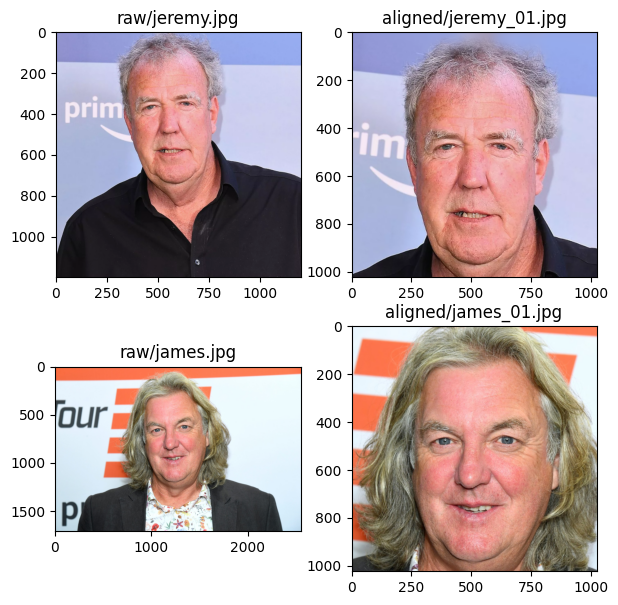

In [ ]:
plt.figure(figsize=(7,7))

plt.subplot(2,2,1).set_title("raw/jeremy.jpg")
plt.imshow(Image.open('raw/jeremy.jpg'))


plt.subplot(2,2,2).set_title("aligned/jeremy_01.jpg")
plt.imshow(Image.open('aligned/jeremy_01.jpg'))


plt.subplot(2,2,3).set_title("raw/james.jpg")
plt.imshow(Image.open('raw/james.jpg'))


plt.subplot(2,2,4).set_title("aligned/james_01.jpg")
plt.imshow(Image.open('aligned/james_01.jpg'))


## Step 2: Projection
Now are images are ready to be projected to the latent space via the GAN model. This is procedure takes a few minutes for each image.

In [ ]:
import os


# source: https://github.com/Pbatch/StyleGANSecretSanta

def project_images(aligned_images_dir, projections_dir):

    for filename in os.listdir(aligned_images_dir):

        target = os.path.join(aligned_images_dir, filename)

        image_name = os.path.basename(target).split('.')[0]
        outdir = f'{projections_dir}/{image_name}'

        if os.path.isdir(outdir):
            continue

        os.makedirs(outdir)

        !python stylegan2-ada-pytorch/projector.py \
            --outdir={outdir} \
            --target={target} \
            --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl \
            --save-video=False

In [ ]:
project_images('aligned/','projections/')

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.66 loss 24567.33
step    2/1000: dist 0.74 loss 27640.72
step    3/1000: dist 0.73 loss 27166.85
step    4/1000: dist 0.53 loss 26253.33
step    5/1000: dist 0.60 loss 24957.22
step    6/1000: dist 0.63 loss 23352.17
step    7/1000: dist 0.52 loss 21510.68
step    8/1000: dist 0.60 loss 19486.88
step    9/1000: dist 0.56 loss 17341.50
step   10/1000: dist 0.59 loss 15140.37
step   11/1000: dist 0.52 loss 12947.

Now we will display the projected images. We don't expect them to be 100% identical to the aligned images.

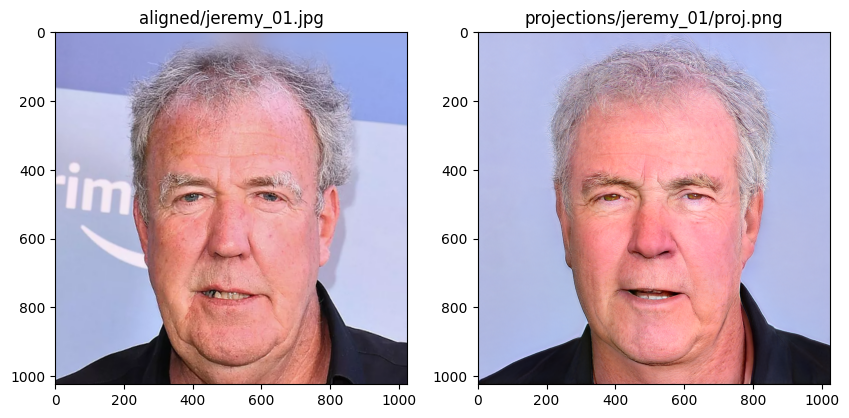

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1).set_title("aligned/jeremy_01.jpg")
plt.imshow(Image.open('aligned/jeremy_01.jpg'))


plt.subplot(1,2,2).set_title("projections/jeremy_01/proj.png")
plt.imshow(Image.open('projections/jeremy_01/proj.png'))



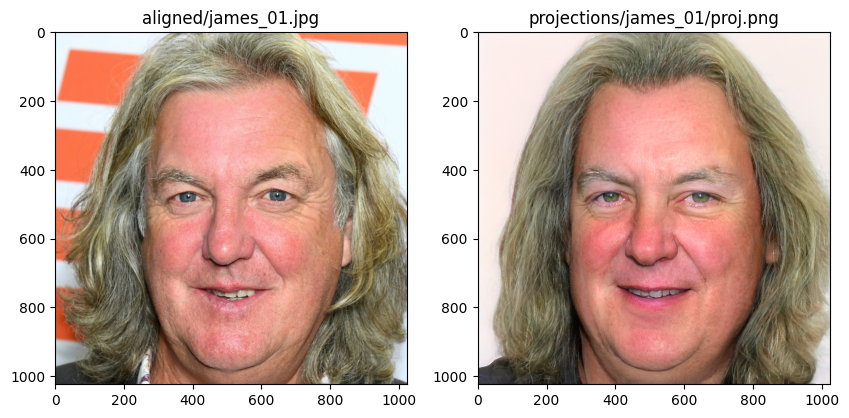

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1).set_title("aligned/james_01.jpg")
plt.imshow(Image.open('aligned/james_01.jpg'))


plt.subplot(1,2,2).set_title("projections/james_01/proj.png")
plt.imshow(Image.open('projections/james_01/proj.png'))

## Step 3: Interpolation (Morphing)

In order to produce morphed images we simply apply interpolation on the latent vectors. During the projection a .npz file was generated for each that contains the cooresponding latent vector.

Assume that $x_1$ and $x_2$ are the latent vectors of image 1 and image 2 accordingly. To get a morphed face we simply do the following:

$$x_m = ( 1- \alpha ) \cdot x_1 + \alpha \cdot x_2$$

Where $\alpha$ is a value in interval $[0,1]$.

In [ ]:
import shutil
import numpy as np

def generate(projections_dir, morphs_dir, image_1, image_2, n_images=6):
    # Delete any old morphs
    morph_dir = os.path.join(morphs_dir, f'{image_1}_{image_2}')
    if os.path.isdir(morph_dir):
        shutil.rmtree(morph_dir)

    image_1_projection = np.load(f'{projections_dir}/{image_1}/projected_w.npz')['w']
    image_2_projection = np.load(f'{projections_dir}/{image_2}/projected_w.npz')['w']
    # Generate `n_images - 2` images (Because we already have the start and end images)
    for i in range(1, n_images-1):
        # Interpolate between the two vectors
        alpha = i / (n_images - 1)
        morph_projection = (1 - alpha) * image_1_projection + alpha * image_2_projection

        # Save the intermediate vector
        alpha_dir = os.path.join(morph_dir, f'{alpha:.3f}')
        morph_path = os.path.join(alpha_dir, 'vector.npz')
        os.makedirs(alpha_dir)
        np.savez(morph_path, w=morph_projection)

        # Generate an image from the intermediate vector
        !python stylegan2-ada-pytorch/generate.py \
            --outdir={alpha_dir} \
            --projected-w={morph_path} \
            --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

In [ ]:
generate('projections', 'morphs', 'james_01', 'jeremy_01', n_images=7)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/james_01_jeremy_01/0.167/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/james_01_jeremy_01/0.333/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/james_01_jeremy_01/0.500/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projecte

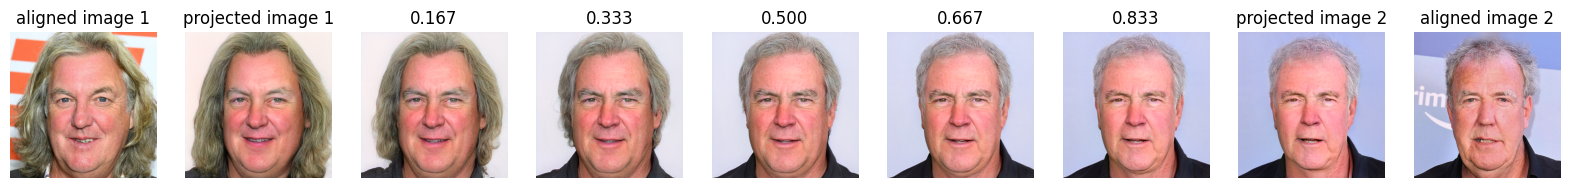

In [ ]:
def show_morphs(aligned_dir, projections_dir, morph_dir, image_1, image_2, n_images):

  total_images = n_images + 2

  plt.figure(figsize=(20,20))

  plt.subplot(1, total_images, 1).set_title("aligned image 1")
  plt.imshow(Image.open(f'{aligned_dir}/{image_1}.jpg'))
  plt.axis('off')

  plt.subplot(1, total_images, 2).set_title("projected image 1")
  plt.imshow(Image.open(f'{projections_dir}/{image_1}/proj.png'))
  plt.axis('off')

  directory = f'{morph_dir}/{image_1}_{image_2}'

  for i,filename in enumerate(sorted(os.listdir(directory))):

        image_path = os.path.join(directory, filename,'proj00.png')

        plt.subplot(1,total_images,i+3).set_title(filename)
        plt.imshow(Image.open(image_path))
        plt.axis('off')

        #print(i+3,image_path)


  plt.subplot(1,total_images, total_images - 1).set_title("projected image 2")
  plt.imshow(Image.open(f'{projections_dir}/{image_2}/proj.png'))
  plt.axis('off')

  plt.subplot(1,total_images, total_images).set_title("aligned image 2")
  plt.imshow(Image.open(f'{aligned_dir}/{image_2}.jpg'))
  plt.axis('off')


show_morphs('aligned', 'projections', 'morphs', 'james_01', 'jeremy_01', 7)

We can repeat this process for other images.

In [ ]:
!wget -P raw/ https://image.tmdb.org/t/p/original/mzHmxtKcMJjDqWxKd67mKQJFW1B.jpg

!wget -P raw/ https://ntvb.tmsimg.com/assets/assets/165127_v9_bd.jpg

# rename image files
!mv raw/mzHmxtKcMJjDqWxKd67mKQJFW1B.jpg raw/michael.jpg
!mv raw/165127_v9_bd.jpg raw/jason.jpg

mkdir: cannot create directory ‘raw’: File exists
--2023-09-22 15:06:07--  https://image.tmdb.org/t/p/original/mzHmxtKcMJjDqWxKd67mKQJFW1B.jpg
Resolving image.tmdb.org (image.tmdb.org)... 18.154.110.63, 18.154.110.116, 18.154.110.123, ...
Connecting to image.tmdb.org (image.tmdb.org)|18.154.110.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373213 (364K) [image/jpeg]
Saving to: ‘raw/mzHmxtKcMJjDqWxKd67mKQJFW1B.jpg’

mzHmxtKcMJjDqWxKd67 100%[===================>] 364.47K  --.-KB/s    in 0.05s   

2023-09-22 15:06:07 (7.18 MB/s) - ‘raw/mzHmxtKcMJjDqWxKd67mKQJFW1B.jpg’ saved [373213/373213]

--2023-09-22 15:06:07--  https://ntvb.tmsimg.com/assets/assets/165127_v9_bd.jpg
Resolving ntvb.tmsimg.com (ntvb.tmsimg.com)... 99.84.166.36, 2600:9000:24d2:5a00:3:aefa:ad1:7fc1, 2600:9000:24d2:800:3:aefa:ad1:7fc1, ...
Connecting to ntvb.tmsimg.com (ntvb.tmsimg.com)|99.84.166.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342967 (335K) [image/

In [ ]:
align_images('raw/', 'aligned/')

<ipython-input-9-4dd43d23884a>:84: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS) # ANTIALIAS is deprecated and will be removed in Pillow 10


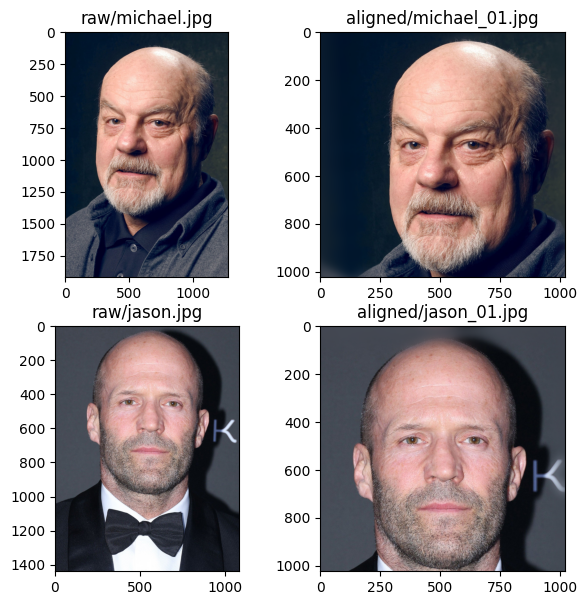

In [ ]:
plt.figure(figsize=(7,7))

plt.subplot(2,2,1).set_title("raw/michael.jpg")
plt.imshow(Image.open('raw/michael.jpg'))


plt.subplot(2,2,2).set_title("aligned/michael_01.jpg")
plt.imshow(Image.open('aligned/michael_01.jpg'))


plt.subplot(2,2,3).set_title("raw/jason.jpg")
plt.imshow(Image.open('raw/jason.jpg'))


plt.subplot(2,2,4).set_title("aligned/jason_01.jpg")
plt.imshow(Image.open('aligned/jason_01.jpg'))

In [ ]:
project_images('aligned/','projections/')

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
step    1/1000: dist 0.70 loss 24567.36
step    2/1000: dist 0.79 loss 27640.77
step    3/1000: dist 0.75 loss 27166.86
step    4/1000: dist 0.61 loss 26253.41
step    5/1000: dist 0.60 loss 24957.21
step    6/1000: dist 0.69 loss 23352.23
step    7/1000: dist 0.57 loss 21510.73
step    8/1000: dist 0.63 loss 19486.91
step    9/1000: dist 0.64 loss 17341.58
step   10/1000: dist 0.61 loss 15140.39
step   11/1000: dist 0.59 loss 12947.

In [ ]:
generate('projections', 'morphs', 'michael_01', 'jason_01', n_images=7)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/michael_01_jason_01/0.167/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/michael_01_jason_01/0.333/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from projected W "morphs/michael_01_jason_01/0.500/vector.npz"
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating images from proje

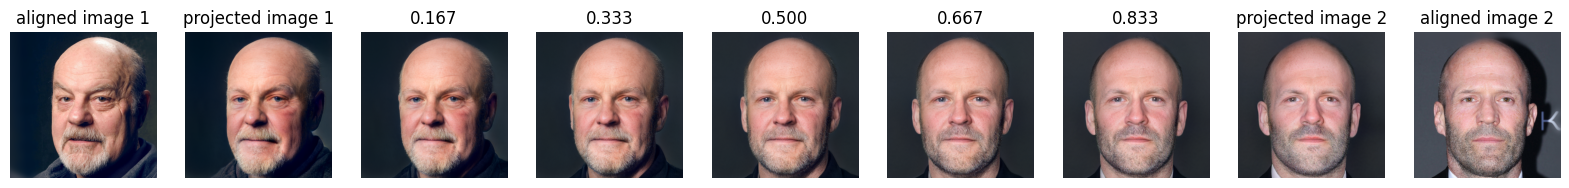

In [ ]:
show_morphs('aligned', 'projections', 'morphs', 'michael_01', 'jason_01', 7)

# Results
As you can see the morphing does work, but the projected images seem to be quite different from the original ones.

Feel free to use this notebook and play around with different images.

# References:
- [woctezuma's fork of Stylegan2](https://github.com/woctezuma/stylegan2/tree/tiled-projector)
- [woctezuma's repository on Image Projection](https://github.com/woctezuma/stylegan2-projecting-images)
- [Pbatch's repository](https://github.com/Pbatch/StyleGANSecretSanta)
